In [1]:
import numpy as np
import pandas as pd
np.random.seed(100) 

from matplotlib import pyplot as plt

In [2]:
city_list = ['Los Angeles', 'New York', 'San Francisco', 'Las Vegas', 'Raleigh', 'Tucson', 'Phoenix', 'Columbus']
year_list = np.arange(2008, 2023)

xvars = {
    'population': {
        'base_range': (1000000, 8000000), 
        'growth': 0.02, 
        'sd': 0.02,
        'coef': 0.1,
    },
    'avg_hh_income': {
        'base_range': (50000, 90000),
        'growth': 0.03,
        'sd': 0.02,
        'coef': 0.2,
    },
    'tourists': {
        'base_range': (100000, 500000),
        'growth': 0.01,
        'sd': 0.04,
        'coef': 0.3,
    }
}

year_fe = {}
for year in year_list:
    year_fe[year] = 0

city_fe = {}
for city in city_list:
    city_fe[city] = np.random.uniform(0, 2)
    
y_sd = 0.01

treatment_year = 2015

treated = {
    'Los Angeles': 1, 
    'New York': 1, 
    'San Francisco': 1, 
    'Las Vegas': 1, 
    'Raleigh': 0, 
    'Tucson': 0, 
    'Phoenix': 0,
    'Columbus': 0,
}

treatment_effect = {
    'Los Angeles': -0.15, 
    'New York': -0.3, 
    'San Francisco': -0.1,
    'Las Vegas': -0.15, 
    'Raleigh': -0.1, 
    'Tucson': -0.05, 
    'Phoenix': -0.15,
    'Columbus': -0.1
}

df = {'city':[], 'year':[], 'airbnb_listings':[], 'population': [], 'avg_hh_income': [], 'tourists': []}
for city in city_list:
    # Initialize x variables
    myx = {}
    for x in xvars:
        myx[x] = np.random.uniform(low=np.log(xvars[x]['base_range'][0]), 
                                          high=np.log(xvars[x]['base_range'][1]))
        
    # City fixed effect
    my_city_fe = city_fe[city]
    
    # Iterate over years
    for year in year_list:
        df['city'].append(city)
        df['year'].append(year)
        
        # Year fixed effect
        my_year_fe = year_fe[year]
        
        # Initialize y
        y = my_city_fe + my_year_fe + np.random.normal(loc=0.0, scale=y_sd)
        
        # Update the x variables
        for x in xvars:
            myx[x] += np.random.normal(loc=xvars[x]['growth'], scale=xvars[x]['sd'])
            y += xvars[x]['coef']*myx[x]
            df[x].append( np.round(np.exp(myx[x])))
        
        # Treatment
        y += (year>treatment_year)*treatment_effect[city]*treated[city] + y_sd
        
        # Finalize y
        df['airbnb_listings'].append(np.round(np.exp(y)))
    
df = pd.DataFrame.from_dict(df)

In [3]:
df

,city,year,airbnb_listings,population,avg_hh_income,tourists
0,Los Angeles,2008,5553.0,1341255.0,71919.0,418677.0
1,Los Angeles,2009,5543.0,1356394.0,73370.0,395738.0
2,Los Angeles,2010,5493.0,1369786.0,76796.0,389388.0
3,Los Angeles,2011,5606.0,1391826.0,77768.0,396920.0
4,Los Angeles,2012,5711.0,1416994.0,82688.0,408959.0
...,...,...,...,...,...,...
115,Columbus,2018,10184.0,1617869.0,100698.0,342452.0
116,Columbus,2019,10105.0,1678779.0,103208.0,350097.0
117,Columbus,2020,10435.0,1738842.0,108231.0,385468.0
118,Columbus,2021,10822.0,1768919.0,115306.0,368431.0


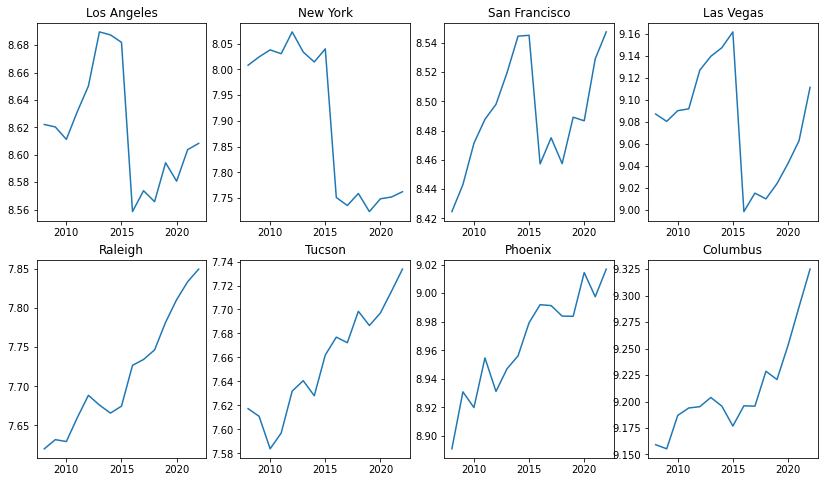

In [4]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
for i, ax in enumerate(axs.flat):
    if i<len(city_list):
        city = city_list[i]
        x = df.loc[ df['city']==city, 'year']
        y = np.log(df.loc[ df['city']==city, 'airbnb_listings'])
        ax.plot(x, y)
        ax.set_title(city)


In [6]:
df.to_csv('../data/airbnb/airbnb.csv', index=False, header=True)